# Stock Market Prediction using Numerical and  Textual Analysis

# Importing Libraries

In [194]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm 

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor

In [195]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import yfinance as yf
train_data = yf.download('^BSESN', start='2015-01-01', end='2020-06-30')

[*********************100%***********************]  1 of 1 completed


In [6]:
train_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200
...,...,...,...,...,...,...
2020-06-23,35015.730469,35482.160156,34843.691406,35430.429688,35430.429688,25200
2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,34868.980469,26600
2020-06-25,34525.390625,35081.609375,34499.781250,34842.101562,34842.101562,24600


In [7]:
test_data = yf.download('^BSESN', start='2020-06-30', end='2020-07-01')

[*********************100%***********************]  1 of 1 completed


In [8]:
train_data.reset_index(inplace=True)

In [9]:
train_data['Date']=pd.to_datetime(train_data['Date'], format = '%Y%m%d')

In [10]:
test_data.reset_index(inplace=True)

In [11]:
test_data['Date']=pd.to_datetime(test_data['Date'], format = '%Y%m%d')

In [12]:
train_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200
...,...,...,...,...,...,...,...
1340,2020-06-23,35015.730469,35482.160156,34843.691406,35430.429688,35430.429688,25200
1341,2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,34868.980469,26600
1342,2020-06-25,34525.390625,35081.609375,34499.781250,34842.101562,34842.101562,24600
1343,2020-06-26,35144.781250,35254.878906,34910.339844,35171.269531,35171.269531,24800


# Creating the Dummy Time Series

In [74]:
def col_breakout(percent,df,column):
    data_set=df.filter(['Date',column],axis=1)
    data_set.set_index('Date',inplace=True)
    data_set['Percentchng']=(data_set[column].pct_change())*100
    data_set['Shock']=data_set['Percentchng'].apply(lambda x:1 if x >= percent else 0)
    data_set.drop(column, axis=1,  inplace = True)
    return data_set.dropna()

In [75]:
col_breakout(2,train_data,'Close')

,Percentchng,Shock
Date,,
2015-01-05,-0.163440,0
2015-01-06,-3.070360,0
2015-01-07,-0.291397,0
2015-01-08,1.359742,0
2015-01-09,0.673407,0
...,...,...
2020-06-23,1.486937,0
2020-06-24,-1.584653,0
2020-06-25,-0.077085,0


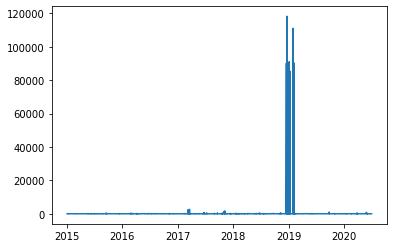

In [77]:
df=col_breakout(10,train_data,'Volume')
df.reset_index(inplace=True)
plt.plot(df['Date'],df['Percentchng'])

In [58]:
def price_breakout(percent, df):
  data = df.filter(['Date', 'High', 'Low','Close'], axis=1) 
  data.set_index('Date', inplace=True)
  data['priceavg'] = (data['High'] + data['Low'] + data['Close']) / 3
  data['shock'] = (data['priceavg'].pct_change()) * 100
  data['shock'] = data['shock'].apply(lambda x: 1 if x >= percent else 0)
  data.drop(['High', 'Low', 'Close'], axis = 1, inplace = True)
  return data

In [59]:
price_breakout(2,train_data)

,priceavg,shock
Date,,
2015-01-02,27781.543620,0
2015-01-05,27897.886719,0
2015-01-06,27207.817057,0
2015-01-07,26912.179688,0
2015-01-08,27231.020182,0
...,...,...
2020-06-23,35252.093750,0
2020-06-24,35123.486979,0
2020-06-25,34807.830729,0


<function matplotlib.pyplot.show(*args, **kw)>

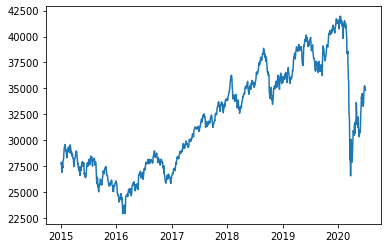

In [78]:
df=price_breakout(2,train_data)
df.reset_index(inplace=True)
plt.plot(df['Date'],df['priceavg'])
plt.show

In [67]:
def reverse_breakout(percent, df, col):
  data = df.filter(['Date', col], axis=1)
  data.set_index('Date', inplace=True)
  data = data.reindex(index=data.index[::-1])
  data['percentchg'] = (data[col].pct_change()) * 100
  data['shock'] = data['percentchg'].apply(lambda x: 1 if x > percent else 0)
  data.drop(col, axis = 1, inplace = True)
  data = data.reindex(index=data.index[::-1])
  return data.dropna()

In [68]:
reverse_breakout(2,train_data,'Volume')

,percentchg,shock
Date,,
2015-01-02,-19.565217,0
2015-01-05,-34.751773,0
2015-01-06,15.573770,1
2015-01-07,48.780488,1
2015-01-08,-26.126126,0
...,...,...
2020-06-22,-0.396825,0
2020-06-23,-5.263158,0
2020-06-24,8.130081,1


<function matplotlib.pyplot.show(*args, **kw)>

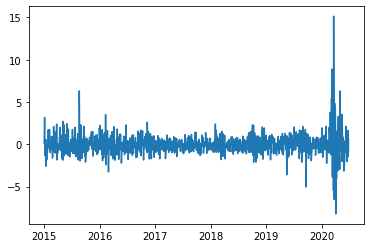

In [81]:
df=reverse_breakout(2,train_data,'Close')
df.reset_index(inplace=True)
plt.plot(df['Date'],df['percentchg'])
plt.show

In [69]:
def pricereverse_breakout(percent, df):
  data = df.filter(['Date', 'High', 'Low','Close'], axis=1) 
  data.set_index('Date', inplace=True)
  data = data.reindex(index=data.index[::-1])
  data['reversepriceavg'] = (data['High'] + data['Low'] + data['Close']) / 3
  data['shock'] = (data['reversepriceavg'].pct_change()) * 100
  data['shock'] = data['shock'].apply(lambda x: 1 if x >= percent else 0)
  data.drop(['High', 'Low', 'Close'], axis = 1, inplace = True)
  data = data.reindex(index=data.index[::-1])
  return data.dropna()

In [70]:
pricereverse_breakout(2,train_data)

,reversepriceavg,shock
Date,,
2015-01-02,27781.543620,0
2015-01-05,27897.886719,1
2015-01-06,27207.817057,0
2015-01-07,26912.179688,0
2015-01-08,27231.020182,0
...,...,...
2020-06-23,35252.093750,0
2020-06-24,35123.486979,0
2020-06-25,34807.830729,0


<function matplotlib.pyplot.show(*args, **kw)>

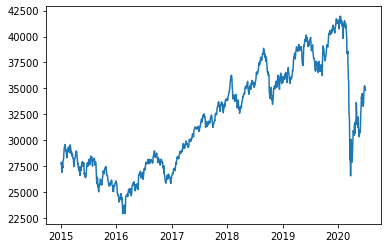

In [82]:
df=pricereverse_breakout(2,train_data)
df.reset_index(inplace=True)
plt.plot(df['Date'],df['reversepriceavg'])
plt.show

# Calculating Moving Averages

In [85]:
def stock_weekmovingavg(wks, df):
  dateclose_data = pd.DataFrame({'Date': df['Date'], 'Close':df['Close']})
  dateclose_data.set_index('Date', inplace=True)
  num = wks * 5 
  dateclose_data['movingavg'] = dateclose_data['Close'].rolling(window=num).mean().shift()
  return dateclose_data.dropna()

In [86]:
stock_weekmovingavg(4, train_data)

,Close,movingavg
Date,,
2015-02-02,29122.269531,28256.509570
2015-02-03,29000.140625,28318.228027
2015-02-04,28883.109375,28376.119043
2015-02-05,28850.970703,28470.901465
2015-02-06,28717.910156,28568.008984
...,...,...
2020-06-23,35430.429688,33521.618164
2020-06-24,34868.980469,33762.674609
2020-06-25,34842.101562,33925.862598


<function matplotlib.pyplot.show(*args, **kw)>

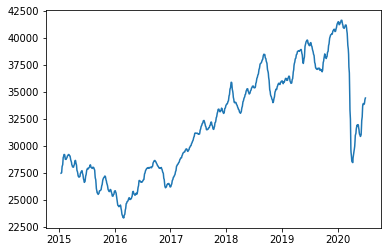

In [87]:
df=stock_weekmovingavg(2,train_data)
df.reset_index(inplace=True)
plt.plot(df['Date'],df['movingavg'])
plt.show

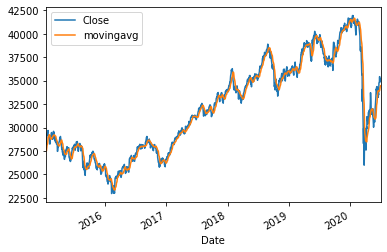

In [88]:
stock_weekmovingavg(2,train_data).plot()
plt.show()

In [89]:
def rollingwindows(days, df):
  data = df.filter(['Date','Open','High','Low','Close'], axis=1)
  data.set_index('Date', inplace=True)
  rollingwindows_data = data.rolling(window=days).mean().shift()
  return rollingwindows_data.dropna()

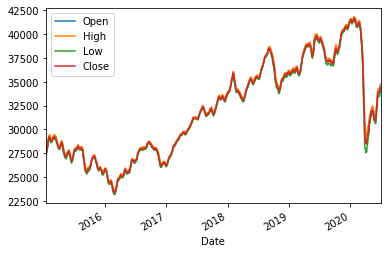

In [90]:
rollingwindows(10,train_data).plot()
plt.show()

# Sentiment Analysis of News Headlines

In [92]:
news  = pd.read_csv('C:/Users/Tejash/Downloads/india-news-headlines.csv')

In [93]:
news.columns

Index(['publish_date', 'headline_category', 'headline_text'], dtype='object')

In [94]:
news['publish_date'] = pd.to_datetime(news['publish_date'], format = '%Y%m%d')

In [95]:
news.head()

,publish_date,headline_category,headline_text
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
2,2001-01-02,unknown,America's unwanted heading for India?
3,2001-01-02,unknown,For bigwigs; it is destination Goa
4,2001-01-02,unknown,Extra buses to clear tourist traffic


In [96]:
news.duplicated().sum()

24191

In [97]:
news.duplicated(keep=False).sum()

46130

In [99]:
cols = list(news.columns)
news.sort_values(by=cols, inplace=True)

In [100]:
news.drop_duplicates(keep='last', inplace=True)

In [101]:
news.duplicated().sum()

0

In [102]:
lst = news['publish_date'].value_counts().index.tolist()

In [103]:
new = []
for x in lst:
  df = news.loc[news['publish_date'] == x]
  headlinetext = ''
  publishdate = str(x)
  headlinetext = df['headline_text'].iloc[0]
  for i in range(1 , len(df)):
    headlinetext = headlinetext + '. '+ df['headline_text'].iloc[i]  
  new.append(headlinetext)

In [129]:
newsdf = pd.DataFrame({'publish_date': lst, 'headline_text' : new})

In [130]:
newsdf

,publish_date,headline_text
0,2014-12-15,Golden Homes III. Golden Panorama. Hanging Gar...
1,2014-12-21,Eight companies add Rs 55;171 crore in m-cap; ...
2,2014-12-09,Audi-Vredestein driving experience. Benelli TN...
3,2014-11-29,6 CARE IPO merchant bankers fined Rs 1 crore. ...
4,2014-11-01,Chetan Bhagat: Cleanliness begins at home. Gau...
...,...,...
7257,2001-03-16,Tape and Tell
7258,2001-03-17,Crouching Tiger; Hidden Dragon
7259,2001-06-05,Darkness Triumphs
7260,2001-04-01,Indians attacked by 'monkey man'


In [131]:
newsdf.sort_values(by='publish_date', inplace=True)

In [132]:
from textblob import TextBlob

In [133]:
polarity = []
subjectivity = []
for idx, row in newsdf.iterrows():
  polarity.append(TextBlob(row['headline_text']).sentiment[0])
  subjectivity.append(TextBlob(row['headline_text']).sentiment[1])
newsdf['polarity'] = polarity
newsdf['subjectivity'] = subjectivity

In [134]:
newsdf['polarity'] = polarity
newsdf['subjectivity'] = subjectivity
newsdf.head()

,publish_date,headline_text,polarity,subjectivity
7121,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...,0.193519,0.293056
7160,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...,0.088462,0.407692
6987,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...,0.091426,0.481895
7132,2001-01-05,Nepal won't allow anti-India activities: Envoy...,0.257415,0.465542
7235,2001-01-06,Anti-immigration think-tank berates Clinton re...,0.219481,0.464935


In [135]:
newsdf.rename(columns={'publish_date': 'Date'}, inplace = True)
newsdf = newsdf.filter(['Date', 'polarity', 'subjectivity'], axis=1)

In [136]:
train_data = pd.merge(train_data, newsdf, how='left', on=['Date'])

In [137]:
train_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,polarity,subjectivity
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400,0.055586,0.455251
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200,0.100081,0.433132
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100,0.055802,0.386579
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200,0.034707,0.386916
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200,0.060173,0.408416


In [138]:
train_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,polarity,subjectivity
1340,2020-06-23,35015.730469,35482.160156,34843.691406,35430.429688,35430.429688,25200,0.067428,0.370002
1341,2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,34868.980469,26600,0.088329,0.387802
1342,2020-06-25,34525.390625,35081.609375,34499.781250,34842.101562,34842.101562,24600,0.023232,0.401736
1343,2020-06-26,35144.781250,35254.878906,34910.339844,35171.269531,35171.269531,24800,0.069594,0.381331
1344,2020-06-29,34926.949219,35032.359375,34662.058594,34961.519531,34961.519531,18300,0.056935,0.387858


# Preparing the Dataset

In [140]:
train_data['Date'] = pd.to_datetime(train_data['Date'], format="%Y-%m-%d")
train_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,polarity,subjectivity,date
1340,2020-06-23,35015.730469,35482.160156,34843.691406,35430.429688,35430.429688,25200,0.067428,0.370002,2020-06-23
1341,2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,34868.980469,26600,0.088329,0.387802,2020-06-24
1342,2020-06-25,34525.390625,35081.609375,34499.781250,34842.101562,34842.101562,24600,0.023232,0.401736,2020-06-25
1343,2020-06-26,35144.781250,35254.878906,34910.339844,35171.269531,35171.269531,24800,0.069594,0.381331,2020-06-26
1344,2020-06-29,34926.949219,35032.359375,34662.058594,34961.519531,34961.519531,18300,0.056935,0.387858,2020-06-29


In [151]:
train_data.drop(columns='date')

,Date,Open,High,Low,Close,Adj Close,Volume,polarity,subjectivity
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400,0.055586,0.455251
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200,0.100081,0.433132
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100,0.055802,0.386579
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200,0.034707,0.386916
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200,0.060173,0.408416
...,...,...,...,...,...,...,...,...,...
1340,2020-06-23,35015.730469,35482.160156,34843.691406,35430.429688,35430.429688,25200,0.067428,0.370002
1341,2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,34868.980469,26600,0.088329,0.387802
1342,2020-06-25,34525.390625,35081.609375,34499.781250,34842.101562,34842.101562,24600,0.023232,0.401736
1343,2020-06-26,35144.781250,35254.878906,34910.339844,35171.269531,35171.269531,24800,0.069594,0.381331


In [153]:
train_data["month"] = train_data['Date'].dt.month
train_data["day"] = train_data['Date'].dt.day
train_data["dayofweek"] = train_data['Date'].dt.dayofweek
train_data["week"] = train_data['Date'].dt.week

In [154]:
train_data['movingavg4weeks'] = round(train_data['Close'].rolling(window=(4*5), min_periods = 1).mean().shift(),2)
train_data['movingavg16weeks'] = round(train_data['Close'].rolling(window=(16*5), min_periods = 1).mean().shift(),2) 
train_data['movingavg28weeks'] = round(train_data['Close'].rolling(window=(28*5), min_periods = 1).mean().shift(),2) 
train_data['movingavg40weeks'] = round(train_data['Close'].rolling(window=(40*5), min_periods = 1).mean().shift(),2)
train_data['movingavg52weeks'] = round(train_data['Close'].rolling(window=(52*5), min_periods = 1).mean().shift(),2)

In [155]:
train_data['window10days'] = round(train_data['Close'].rolling(window = 10, min_periods = 1).mean().shift(),2)  
train_data['window50days'] = round(train_data['Close'].rolling(window = 50, min_periods = 1).mean().shift(),2)

In [158]:
train_data['volumeshock'] = round(col_breakout(10, train_data, 'Volume').reset_index()['Shock'], 2)
train_data['closeshock2'] = round(reverse_breakout(2, train_data, 'Close').reset_index()['shock'], 2)
train_data['closeshock5'] = round(reverse_breakout(5, train_data, 'Close').reset_index()['shock'],2)
train_data['closeshock10'] = round(reverse_breakout(10, train_data, 'Close').reset_index()['shock'], 2)

In [162]:
train_data['priceshock'] = round(price_breakout(10, train_data).reset_index()['shock'], 2)
train_data['reversebooleanshock2'] = round(pricereverse_breakout(2, train_data).reset_index()['shock'], 2)
train_data['reversebooleanshock5'] = round(pricereverse_breakout(5, train_data).reset_index()['shock'], 2)

In [165]:
train_data['polarity'] = round(train_data['polarity'] , 2)
train_data['subjectivity'] = round(train_data['subjectivity'] , 2)
train_data['price'] = round((train_data['High'] + train_data['Low'] + train_data['Close']) / 3 , 2)
train_data['Close'] = round(train_data['Close'] , 2)

In [166]:
train_data

,Date,Open,High,Low,Close,Adj Close,Volume,polarity,subjectivity,date,...,window10days,window50days,volumeshock,closeshock2,closeshock5,closeshock10,priceshock,reversebooleanshock2,reversebooleanshock5,price
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.90,27887.900391,7400,0.06,0.46,2015-01-02,...,NaN,NaN,1.0,0.0,0.0,0.0,0,0,0,27781.54
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.32,27842.320312,9200,0.10,0.43,2015-01-05,...,27887.90,27887.90,1.0,1.0,0.0,0.0,0,1,0,27897.89
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.46,26987.460938,14100,0.06,0.39,2015-01-06,...,27865.11,27865.11,0.0,0.0,0.0,0.0,0,0,0,27207.82
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.82,26908.820312,12200,0.03,0.39,2015-01-07,...,27572.56,27572.56,0.0,0.0,0.0,0.0,0,0,0,26912.18
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.71,27274.710938,8200,0.06,0.41,2015-01-08,...,27406.63,27406.63,1.0,0.0,0.0,0.0,0,0,0,27231.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,2020-06-23,35015.730469,35482.160156,34843.691406,35430.43,35430.429688,25200,0.07,0.37,2020-06-23,...,33971.60,32192.97,0.0,0.0,0.0,0.0,0,0,0,35252.09
1341,2020-06-24,35679.738281,35706.550781,34794.929688,34868.98,34868.980469,26600,0.09,0.39,2020-06-24,...,34118.98,32303.70,0.0,0.0,0.0,0.0,0,0,0,35123.49
1342,2020-06-25,34525.390625,35081.609375,34499.781250,34842.10,34842.101562,24600,0.02,0.40,2020-06-25,...,34181.17,32377.89,0.0,0.0,0.0,0.0,0,0,0,34807.83
1343,2020-06-26,35144.781250,35254.878906,34910.339844,35171.27,35171.269531,24800,0.07,0.38,2020-06-26,...,34311.54,32460.93,0.0,0.0,0.0,0.0,0,0,0,35112.16


In [167]:
train_data.fillna(method = 'bfill', inplace = True)

In [182]:
train_data.fillna(method = 'ffill', inplace = True)

In [183]:
train_data = train_data.filter(['month', 'day', 'dayofweek', 'week',
       'movingavg4weeks', 'movingavg16weeks', 'movingavg28weeks',
       'movingavg40weeks', 'movingavg52weeks', 'window10days', 'window50days',
       'volumeshock', 'closeshock2', 'closeshock5', 'closeshock10',
       'priceshock', 'reversebooleanshock2', 'reversebooleanshock5',
       'pricereverseshock2', 'polarity', 'subjectivity', 'price', 'Close'], axis=1)

In [184]:
train_data

,month,day,dayofweek,week,movingavg4weeks,movingavg16weeks,movingavg28weeks,movingavg40weeks,movingavg52weeks,window10days,...,closeshock2,closeshock5,closeshock10,priceshock,reversebooleanshock2,reversebooleanshock5,polarity,subjectivity,price,Close
0,1,2,4,1,27887.90,27887.90,27887.90,27887.90,27887.90,27887.90,...,0.0,0.0,0.0,0,0,0,0.06,0.46,27781.54,27887.90
1,1,5,0,2,27887.90,27887.90,27887.90,27887.90,27887.90,27887.90,...,1.0,0.0,0.0,0,1,0,0.10,0.43,27897.89,27842.32
2,1,6,1,2,27865.11,27865.11,27865.11,27865.11,27865.11,27865.11,...,0.0,0.0,0.0,0,0,0,0.06,0.39,27207.82,26987.46
3,1,7,2,2,27572.56,27572.56,27572.56,27572.56,27572.56,27572.56,...,0.0,0.0,0.0,0,0,0,0.03,0.39,26912.18,26908.82
4,1,8,3,2,27406.63,27406.63,27406.63,27406.63,27406.63,27406.63,...,0.0,0.0,0.0,0,0,0,0.06,0.41,27231.02,27274.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,6,23,1,26,33521.62,32658.27,36304.08,37008.50,37384.51,33971.60,...,0.0,0.0,0.0,0,0,0,0.07,0.37,35252.09,35430.43
1341,6,24,2,26,33762.67,32586.53,36265.58,37002.15,37367.90,34118.98,...,0.0,0.0,0.0,0,0,0,0.09,0.39,35123.49,34868.98
1342,6,25,3,26,33925.86,32517.85,36221.64,36989.02,37350.08,34181.17,...,0.0,0.0,0.0,0,0,0,0.02,0.40,34807.83,34842.10
1343,6,26,4,26,34057.94,32449.86,36176.72,36975.03,37330.89,34311.54,...,0.0,0.0,0.0,0,0,0,0.07,0.38,35112.16,35171.27


# Training the Model

In [185]:
X = train_data.drop(['price','Close'], axis = 1)
y = train_data[['price','Close']]

In [186]:
from sklearn.model_selection import train_test_split

In [187]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [188]:
model = RandomForestRegressor(random_state = 42, n_estimators = 500, criterion='mse', max_depth = 30, min_samples_leaf=2, min_samples_split=5, n_jobs=1)

In [189]:
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [190]:
pred = model.predict(X_test)
roundpred = []
for x in range(len(pred)):
  roundpred.append([round(pred[x][0], 2),round(pred[x][1], 2) ])

In [191]:
r2_score(y_test, roundpred)

0.9906275196870586

In [192]:
print('MAE')
print(mean_absolute_error(y_test, roundpred), end='\n')
print('MSE')
print(mean_squared_error(y_test, roundpred), end='\n')
print('RMSE')
print(np.sqrt(mean_squared_error(y_test, roundpred)))

MAE
265.54635687732355
MSE
236937.47145092953
RMSE
486.7622329751247
